# Exploration of new techniques to build a connectome
The aim of this notebook is to test various ideas to try to avoid the construction of a differential network.

In [3]:
import pandas as pd
import numpy as np
import random
import warnings

from scipy.linalg import eigvalsh
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from utilsData import load_data_from_patients_folder, add_mean_SUV_index
from utilsStats import build_correlation_matrix, build_graph_from_correlation_df, build_significance_matrix_for_diff, is_connected
from utilsVisual import plot_correlogram, plot_connectome
from utilsClustering import custom_spectral_clustering_on_similarity_matrix, compute_frobenius_similarity, compute_cosine_similarity, compute_spectral_distance, compute_deltaCon_distance, compute_cut_distance

random.seed(2003)
np.random.seed(2003) 

In [4]:

patients_data = load_data_from_patients_folder("../Data/PATIENTS")
patients_data = add_mean_SUV_index(patients_data)

controls_data = load_data_from_patients_folder("../Data/CONTROLES")
controls_data = add_mean_SUV_index(controls_data)

patients = patients_data.keys()
controls = controls_data.keys()

patients_list = list(patients)
controls_list = list(controls)

names = patients_data[list(patients)[0]].loc["name"]
names = names.to_numpy()

print(f"Loaded data for {len(patients_data)}-{len(controls_data)} patients.")

Loaded data for 27-53 patients.


In [ ]:
normal_group = [patients_data[item].loc["mean_SUV"].to_numpy() for item in patients_list]

In [ ]:
import numpy as np
from scipy.stats import entropy
from scipy.stats import ttest_ind

def js_divergence(p, q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

# Example usage
normal_group = [patients_data[item].loc["mean_SUV"].to_numpy() / max(patients_data[item].loc["mean_SUV"].to_numpy()) for item in patients_list]
new_dist = controls_data[controls_list[0]].loc["mean_SUV"].to_numpy() / max(controls_data[controls_list[0]].loc["mean_SUV"].to_numpy())

jsds = [js_divergence(new_dist, d) for d in normal_group]
average_jsd = np.mean(jsds)
print(f"Average JS Divergence: {average_jsd}")
print("------")
patients_div = []
for item in patients_list:
    jsds = [js_divergence(patients_data[item].loc["mean_SUV"].to_numpy()/max(patients_data[item].loc["mean_SUV"].to_numpy()), d) for d in normal_group]
    average_jsd = np.mean(jsds)
    #print(f"Average JS Divergence: {average_jsd}")
    patients_div.append(average_jsd)
print("------")
controls_div = []
for item in controls_list:
    jsds = [js_divergence(controls_data[item].loc["mean_SUV"].to_numpy()/max(controls_data[item].loc["mean_SUV"].to_numpy()), d) for d in normal_group]
    average_jsd = np.mean(jsds)
    controls_div.append(average_jsd)
    #print(f"Average JS Divergence: {average_jsd}")

print(np.mean(patients_div), np.mean(controls_div))
print(np.var(patients_div), np.var(controls_div))


# Perform an independent t-test
t_stat, p_value = ttest_ind(patients_div, controls_div, equal_var=False)  # Welch's t-test

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Common significance level
if p_value < alpha:
    print("There is a statistically significant difference between patients and controls (p < 0.05).")
else:
    print("No statistically significant difference found (p >= 0.05).")


In [99]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_density(vector, title="Density Plot"):
  """
  Plots the density of a 1D vector.

  Args:
    vector: A list or numpy array representing the data.
    title: The title of the plot.
  """
  if not isinstance(vector, (list, np.ndarray)):
    raise TypeError("Input 'vector' must be a list or numpy array.")

  if isinstance(vector, list):
    vector = np.array(vector)

  plt.figure(figsize=(10, 5))
  sns.kdeplot(vector, fill=True)  # Use seaborn for a smooth density plot
  plt.title(title)
  plt.xlabel("Value")
  plt.ylabel("Density")
  plt.grid(True)
  plt.show()
  
def plot_distribution_vector(vector_of_distributions, title="Distribution Vector"):
    """
    Plots a vector of distributions using overlapping density plots.

    Args:
      vector_of_distributions: A list of lists or numpy arrays, where each inner 
                                list/array represents a distribution.
      title: The title of the plot.
    """
    plt.figure(figsize=(10, 5))
    for distribution in vector_of_distributions:
        sns.kdeplot(distribution, fill=True)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

In [ ]:
plot_distribution_vector([patients_data[item][10]["SUV"]/max(patients_data[item][10]["SUV"]) for item in patients_list])

In [ ]:
plot_distribution_vector([controls_data[item][10]["SUV"]/max(controls_data[item][10]["SUV"]) for item in controls_list])

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def check_distribution_type_with_tail_removal(vector_of_distributions, alpha=0.05):
    """
    Checks distribution types, first with original data, then after removing the top 5% of values.

    Args:
        vector_of_distributions: A list of lists or numpy arrays.
        alpha: Significance level for tests.

    Returns:
        A tuple of two lists: original results and results after tail removal.
    """

    original_results = []
    tail_removed_results = []

    for i, distribution in enumerate(vector_of_distributions):
        distribution = np.array(distribution)

        # Original data tests
        original_result = perform_distribution_tests(distribution, alpha, i, "Original")
        original_results.append(original_result)

        # Remove top 5% and perform tests again
        threshold = np.percentile(distribution, (1-alpha)*100)
        trimmed_distribution = distribution[distribution <= threshold]

        tail_removed_result = perform_distribution_tests(trimmed_distribution, alpha, i, "Tail Removed")
        tail_removed_results.append(tail_removed_result)

    return original_results, tail_removed_results

def perform_distribution_tests(distribution, alpha, index, data_label):
    """
    Performs the distribution tests and generates Q-Q plots.
    """
    shapiro_stat, shapiro_p = stats.shapiro(distribution)
    ks_lognorm_stat, ks_lognorm_p = stats.kstest(distribution, 'lognorm', args=(np.mean(np.log(distribution)), np.std(np.log(distribution))))

    try:
        params = stats.gamma.fit(distribution, floc=0)
        ks_gamma_stat, ks_gamma_p = stats.kstest(distribution, 'gamma', args=params)
    except (ValueError, ZeroDivisionError) as e:
        print(f"Warning: Gamma fit failed for distribution {index} ({data_label}): {e}")
        ks_gamma_stat, ks_gamma_p = np.nan, np.nan

    result = {
        "distribution_index": index,
        "shapiro_stat": shapiro_stat,
        "shapiro_p": shapiro_p,
        "normal": shapiro_p > alpha,
        "ks_lognorm_stat": ks_lognorm_stat,
        "ks_lognorm_p": ks_lognorm_p,
        "lognormal": ks_lognorm_p > alpha,
        "ks_gamma_stat": ks_gamma_stat,
        "ks_gamma_p": ks_gamma_p,
        "gamma": ks_gamma_p > alpha if not np.isnan(ks_gamma_p) else False,
        "data_label" : data_label
    }

    # QQ plots
    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    stats.probplot(distribution, dist="norm", plot=plt)
    plt.title(f"Distribution {index} ({data_label}) - Normal Q-Q Plot")

    plt.subplot(1, 3, 2)
    stats.probplot(distribution, dist=stats.lognorm(s=np.std(np.log(distribution)), scale=np.exp(np.mean(np.log(distribution)))), plot=plt)
    plt.title(f"Distribution {index} ({data_label}) - Log-Normal Q-Q Plot")

    plt.subplot(1, 3, 3)
    if not np.isnan(ks_gamma_p):
        stats.probplot(distribution, dist=stats.gamma(a=params[0], loc=params[1], scale=params[2]), plot=plt)
        plt.title(f"Distribution {index} ({data_label}) - Gamma Q-Q Plot")
    else:
        plt.text(0.5, 0.5, "Gamma fit failed", ha='center', va='center')

    plt.tight_layout()
    #plt.show()

    return result

In [ ]:

#results = check_distribution_type([np.exp(controls_data[item][10]["SUV"]) for item in controls_list])
#for result in results:
#    print(f"Distribution {result['distribution_index']}:")
#    print(f"  Normal: {result['normal']} (Shapiro-Wilk p-value: {result['shapiro_p']})")
#    print(f"  Lognormal: {result['lognormal']} (KS p-value: {result['ks_lognorm_p']})")
#    print(f"  Gamma: {result['gamma']} (KS p-value: {result['ks_gamma_p']})")
#    print("-" * 20)

original_results, tail_removed_results = check_distribution_type_with_tail_removal([controls_data[item][10]["SUV"] for item in controls_list], alpha=0.01)

print("Original Data Results:")
for result in original_results:
    print(f"Distribution {result['distribution_index']} ({result['data_label']}):")
    print(f"  Normal: {result['normal']} (Shapiro-Wilk p-value: {result['shapiro_p']})")
    print(f"  Lognormal: {result['lognormal']} (KS p-value: {result['ks_lognorm_p']})")
    print(f"  Gamma: {result['gamma']} (KS p-value: {result['ks_gamma_p']})")
    print("-" * 20)

print("\nTail Removed Results:")
for result in tail_removed_results:
    print(f"Distribution {result['distribution_index']} ({result['data_label']}):")
    print(f"  Normal: {result['normal']} (Shapiro-Wilk p-value: {result['shapiro_p']})")
    print(f"  Lognormal: {result['lognormal']} (KS p-value: {result['ks_lognorm_p']})")
    print(f"  Gamma: {result['gamma']} (KS p-value: {result['ks_gamma_p']})")
    print("-" * 20)

In [ ]:
patients_data[patients_list[0]].loc["SUV"]

In [ ]:
[patients_data[item][10]["SUV"]/max(patients_data[item][10]["SUV"]) for item in patients_list]

### Experiment A: Let's build individual connectomes

In [31]:
import numpy as np

def build_adjacency_matrix(organs, metric="kl_divergence", threshold=None, k=None):
    """
    Build the adjacency matrix for a graph of organs based on log-normal distribution parameters.

    Parameters:
        organs (dict): Dictionary where keys are organ names and values are (mean, variance) tuples.
        metric (str): Distance metric to use ("kl_divergence", "euclidean-on-log", "bhattacharyya").
        threshold (float, optional): Maximum allowed distance to connect nodes (used for threshold-based graphs).
        k (int, optional): Number of nearest neighbors to connect each node (used for k-NN graphs).

    Returns:
        np.ndarray: Adjacency matrix (symmetric).
        list: Ordered list of organ names corresponding to matrix indices.
    """
    organ_names = list(organs.keys())
    num_organs = len(organ_names)
    
    # Convert organ dictionary to a NumPy array for easier computation
    organ_vectors = np.array([organs[name] for name in organ_names])
    
    # Convert (mean, variance) to underlying normal parameters (mu, sigma²)
    log_mu = np.log(organ_vectors[:, 0]**2 / np.sqrt(organ_vectors[:, 1] + organ_vectors[:, 0]**2))
    log_sigma_sq = np.log(organ_vectors[:, 1] / organ_vectors[:, 0]**2 + 1)

    # Compute pairwise distances
    distance_matrix = np.zeros((num_organs, num_organs))

    if metric == "kl_divergence":
        def kl_divergence(i, j):
            mu1, sigma1_sq = log_mu[i], log_sigma_sq[i]
            mu2, sigma2_sq = log_mu[j], log_sigma_sq[j]
            return 0.5 * (sigma2_sq / sigma1_sq + (mu1 - mu2)**2 / sigma1_sq - 1 + np.log(sigma1_sq / sigma2_sq))

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = kl_divergence(i, j) + kl_divergence(j, i)  # Symmetric KL divergence
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Ensure symmetry

    elif metric == "euclidean-on-log":
        # Compute Euclidean distance between (log_mu, log_sigma_sq) representations
        log_vectors = np.vstack((log_mu, log_sigma_sq)).T
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = np.linalg.norm(log_vectors[i] - log_vectors[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Ensure symmetry

    elif metric == "bhattacharyya":
        def bhattacharyya(i, j):
            mu1, sigma1_sq = log_mu[i], log_sigma_sq[i]
            mu2, sigma2_sq = log_mu[j], log_sigma_sq[j]
            return 0.25 * np.log(0.25 * (sigma1_sq / sigma2_sq + sigma2_sq / sigma1_sq + 2)) + \
                   0.25 * ((mu1 - mu2)**2 / (sigma1_sq + sigma2_sq))

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = bhattacharyya(i, j)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Ensure symmetry

    else:
        raise ValueError("Unsupported metric. Choose 'kl_divergence', 'euclidean-on-log', or 'bhattacharyya'.")

    # Build adjacency matrix based on threshold or k-NN
    adjacency_matrix = np.zeros((num_organs, num_organs))

    if threshold is not None:
        if threshold != 0:
            adjacency_matrix[distance_matrix < threshold] = 1
        else:    
            adjacency_matrix = np.max(distance_matrix) - distance_matrix

    elif k is not None:
        for i in range(num_organs):
            nearest_indices = np.argsort(distance_matrix[i])[1:k+1]  # Exclude self (index 0)
            adjacency_matrix[i, nearest_indices] = 1
            adjacency_matrix[nearest_indices, i] = 1  # Ensure symmetry

    np.fill_diagonal(adjacency_matrix, 0)  # No self-loops

    return adjacency_matrix, organ_names


def build_organ_dict(organ_SUV_values):
    """
    Constructs an organ dictionary with (mean, variance) for each organ based on SUV values.

    Parameters:
        patients_data (dict): Dictionary where keys are patient IDs and values are pandas DataFrames.
        patients_list (list): List of patient IDs to aggregate data from.

    Returns:
        dict: {organ_name: (mean_SUV, variance_SUV)}
    """

    organ_dict = {}

    for i, arr in enumerate(organ_SUV_values):
        mean = np.mean(arr)
        variance = np.var(arr)
        organ_dict[i] = (mean, variance)

    return organ_dict

def normalize_matrix_no_diagonal(matrix):
    """
    Normalizes a matrix (min-max scaling) while ignoring the diagonal.

    Args:
        matrix: A NumPy array (matrix) to normalize.

    Returns:
        A normalized NumPy array.
    """
    matrix = matrix.astype(float) #Ensure it's a float matrix.
    diagonal = np.diag(matrix).copy() #Store the diagonal values.
    np.fill_diagonal(matrix, np.nan) #Temporarily set diagonal to NaN.

    min_val = np.nanmin(matrix)
    max_val = np.nanmax(matrix)

    if max_val == min_val:
        # Handle the case where all off-diagonal elements are the same
        normalized_matrix = np.zeros_like(matrix)
    else:
        normalized_matrix = (matrix - min_val) / (max_val - min_val)

    np.fill_diagonal(normalized_matrix, diagonal) #Restore the original diagonal.
    return normalized_matrix



In [40]:
patients_connectomes = {}
controls_connectomes = {}

for patient in patients_list:
    organs_raw = patients_data[patient].loc["SUV"].to_numpy()
    organs = build_organ_dict(organs_raw)
    adj_matrix, organ_names = build_adjacency_matrix(organs, metric="bhattacharyya", threshold=0)
    adj_matrix2, organ_names2 = build_adjacency_matrix(organs, metric="kl_divergence", threshold=0)
    adj_matrix3, organ_names3 = build_adjacency_matrix(organs, metric="euclidean-on-log", threshold=0)
    patients_connectomes[patient] = {'bhattacharyya': normalize_matrix_no_diagonal(adj_matrix), 
                                     'kl_divergence': normalize_matrix_no_diagonal(adj_matrix2), 
                                     'euclidean-on-log': normalize_matrix_no_diagonal(adj_matrix3), 
                                     'organs': organs}

for patient in controls_list:
    organs_raw = controls_data[patient].loc["SUV"].to_numpy()
    organs = build_organ_dict(organs_raw)
    adj_matrix, organ_names = build_adjacency_matrix(organs, metric="bhattacharyya", threshold=0)
    adj_matrix2, organ_names2 = build_adjacency_matrix(organs, metric="kl_divergence", threshold=0)
    adj_matrix3, organ_names3 = build_adjacency_matrix(organs, metric="euclidean-on-log", threshold=0)
    controls_connectomes[patient] = {'bhattacharyya': normalize_matrix_no_diagonal(adj_matrix), 
                                     'kl_divergence': normalize_matrix_no_diagonal(adj_matrix2), 
                                     'euclidean-on-log': normalize_matrix_no_diagonal(adj_matrix3), 
                                     'organs': organs}


In [38]:
import matplotlib.pyplot as plt

def print_adjacency_matrices(data_patient):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    im1 = axes[0].imshow(data_patient['bhattacharyya'], cmap='viridis', interpolation='nearest')
    axes[0].set_title('Adjacency Matrix (bhattacharyya)')
    axes[0].set_xlabel('Node')
    axes[0].set_ylabel('Node')
    fig.colorbar(im1, ax=axes[0])

    # Plot the second matrix
    im2 = axes[1].imshow(data_patient['kl_divergence'], cmap='viridis', interpolation='nearest')
    axes[1].set_title('Adjacency Matrix (kl_divergence)')
    axes[1].set_xlabel('Node')
    axes[1].set_ylabel('Node')
    fig.colorbar(im2, ax=axes[1])

    # Plot the third matrix
    im3 = axes[2].imshow(data_patient['euclidean-on-log'], cmap='viridis', interpolation='nearest')
    axes[2].set_title('Adjacency Matrix (euclidean-on-log)')
    axes[2].set_xlabel('Node')
    axes[2].set_ylabel('Node')
    fig.colorbar(im3, ax=axes[2])

    plt.tight_layout() #Prevents overlapping titles/labels.
    plt.show()

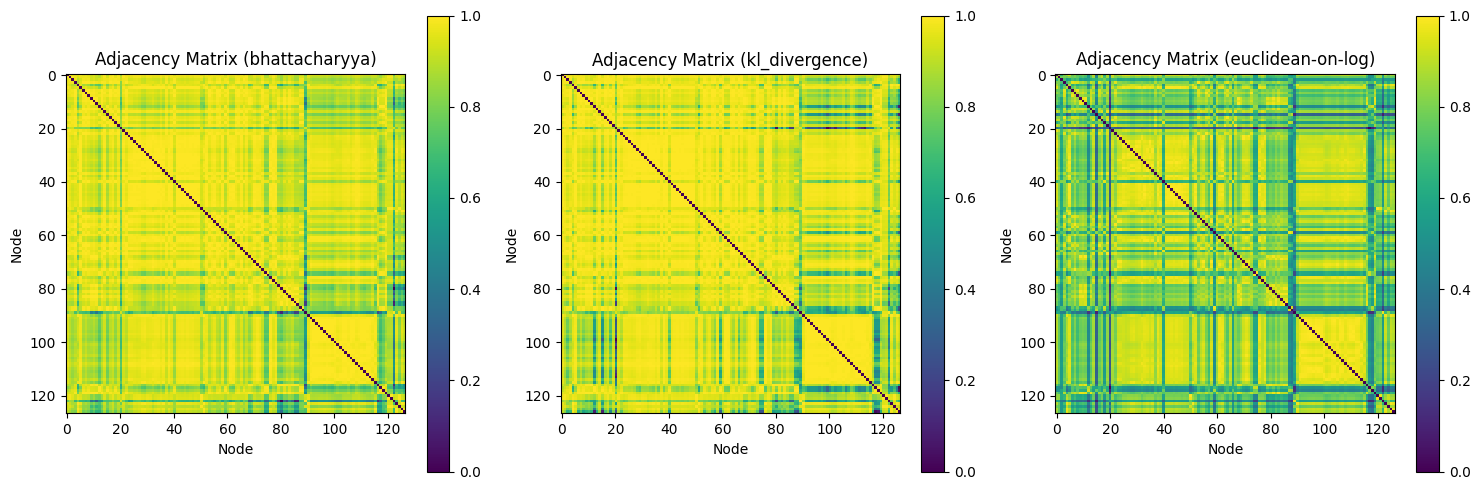

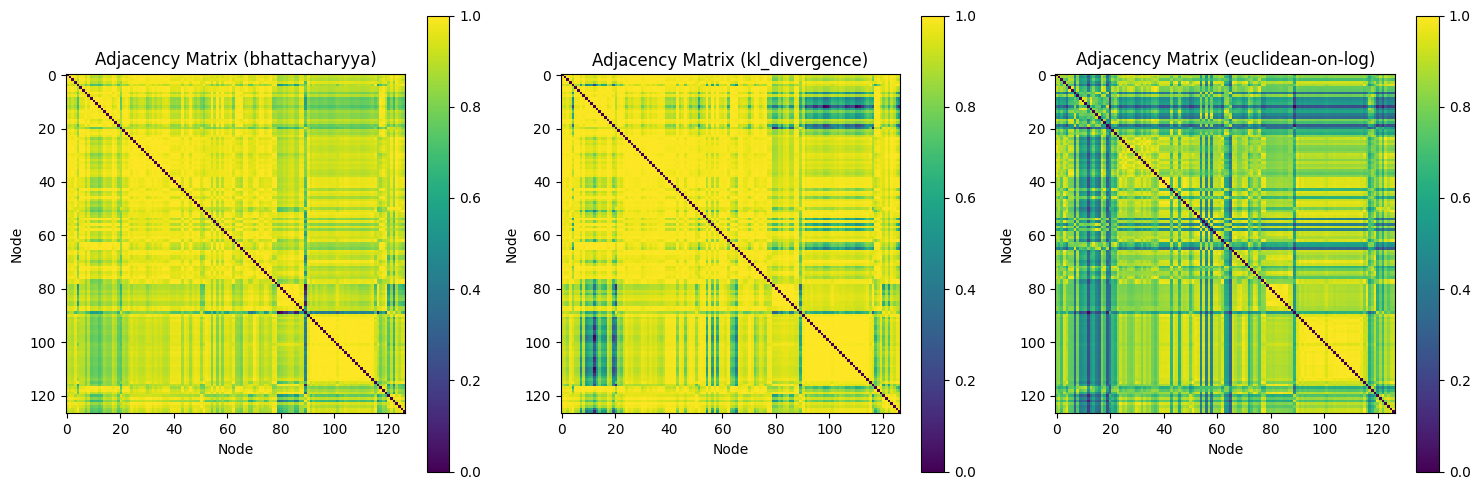

In [42]:
print_adjacency_matrices(patients_connectomes[patients_list[0]])

print_adjacency_matrices(controls_connectomes[controls_list[0]])

##### Now that we do have our individual connectomes, we try direct clustering...
...but it's a fail

Cluster labels: [1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1
 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 1 1 0 0 1 0]
Cluster labels (after PCA): [0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0
 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0
 0 0 1 1 0 1]


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_51024/3823648196.py:4: UserWarning: The adjacency matrix is not associated with a fully connected graph.
  warnings.warn("The adjacency matrix is not associated with a fully connected graph.")


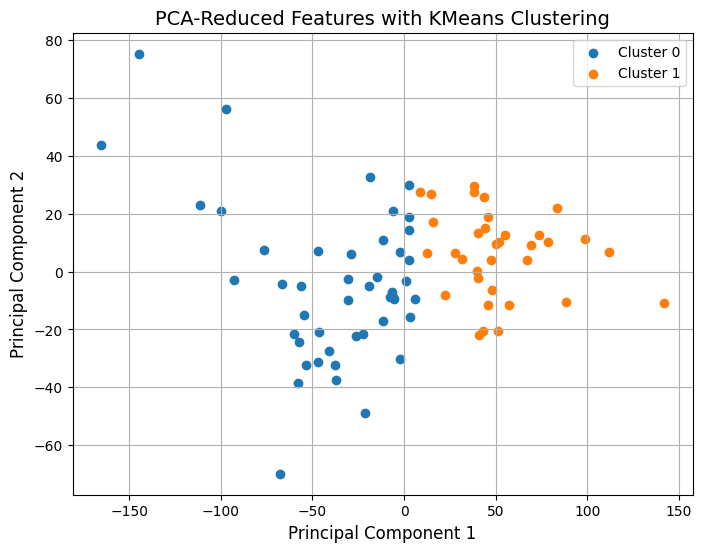

In [57]:
# Compute spectral features (e.g., eigenvalues of the graph Laplacian)
def compute_spectral_features(adj_matrix):
    if is_connected(adj_matrix) is not True:
        warnings.warn("The adjacency matrix is not associated with a fully connected graph.")
    degree_matrix = np.diag(adj_matrix.sum(axis=1))
    laplacian = degree_matrix - adj_matrix
    eigenvalues = eigvalsh(laplacian)
    return eigenvalues
    
features = [
    compute_spectral_features(
        #np.where(np.abs(test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy()) < 0.3, 0, 
        #         test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy())
        patient_matrices['euclidean-on-log']
    )
    for patient_matrices in (patients_connectomes | controls_connectomes).values()
]

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

print("Cluster labels:", labels)

# Reduce dimensions (optional)
from sklearn.decomposition import PCA
features_reduced = PCA(n_components=2).fit_transform(features)

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_reduced)

print("Cluster labels (after PCA):", labels)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(
        features_reduced[labels == label, 0],  # x-coordinates for the cluster
        features_reduced[labels == label, 1],  # y-coordinates for the cluster
        label=f"Cluster {label}"
    )

# Add labels and legend
plt.title("PCA-Reduced Features with KMeans Clustering", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Clusters are not separated...

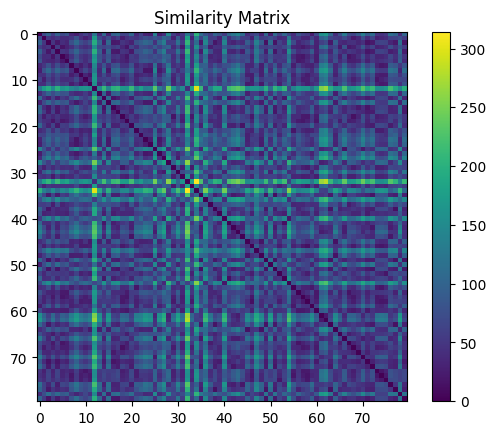

Cluster labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0]


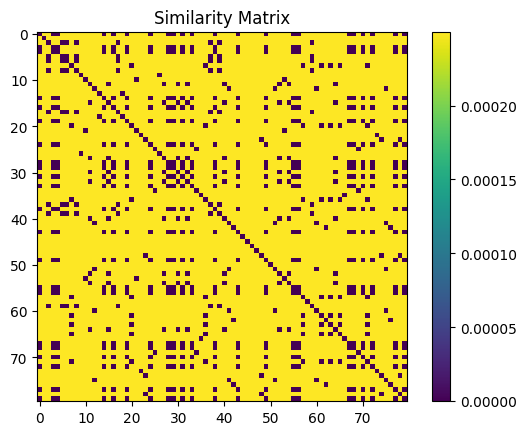

Cluster labels: [0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1
 0 0 0 0 0 0]


In [62]:
adj_matrices = [
    patient_matrices['euclidean-on-log']
    for patient_matrices in (patients_connectomes | controls_connectomes).values()
]
for adj in adj_matrices:
    np.fill_diagonal(adj, 0)  # Remove self-loops

print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_spectral_distance(adj_matrices)))

print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_cut_distance(adj_matrices)))

##### Let's try to build a reference matrix


In [ ]:
reference_matrix = np.mean([
    patient_matrices['kl_divergence']
    for patient_matrices in patients_connectomes.values()
])
distance_to_ref_patients = [
    (reference_matrix - patient_matrices['kl_divergence'])
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls = [
    (reference_matrix - patient_matrices['kl_divergence'])
    for patient_matrices in (controls_connectomes).values()]

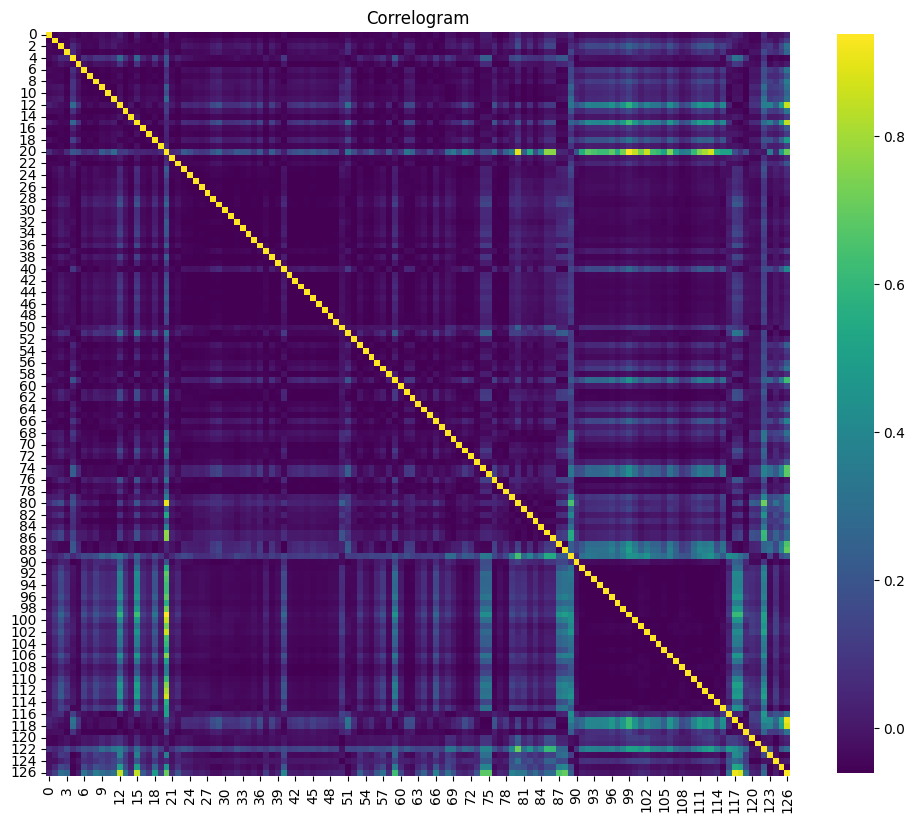

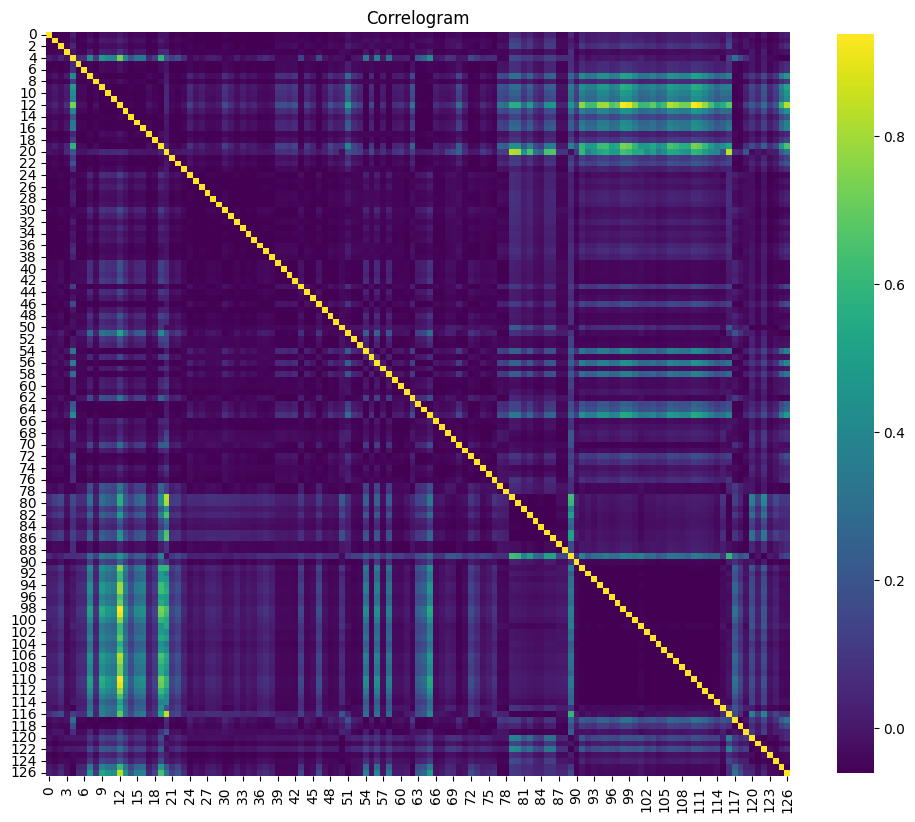

In [127]:
plot_correlogram(distance_to_ref_patients[0])
plot_correlogram(distance_to_ref_controls[0])

In [ ]:
print(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1), np.mean(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1)))
print(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1), np.mean(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1)))

(27, 127, 127)
[ 0.02053262 -0.00554268 -0.01548013 -0.01354434 -0.01411766 -0.01733902
  0.00932745 -0.00051216  0.01682635 -0.0033945   0.0076931   0.00636443
  0.01498859  0.0291586  -0.0094977   0.02299417 -0.01231547 -0.00950938
 -0.00932727 -0.00677125 -0.02184067  0.00528178 -0.00087486  0.02990466
 -0.01289039 -0.02344222  0.01332795] -8.4872952287606e-17
[ 0.02698356 -0.02609408 -0.00739107  0.02327745 -0.00850154  0.03405147
 -0.00572983 -0.03233871 -0.01934425  0.00162109  0.01685674 -0.02391022
 -0.00062147  0.02967315 -0.01353755 -0.02111855 -0.0253124  -0.02773352
 -0.00550102  0.00012054  0.00727115  0.01108785 -0.02920634  0.0210887
 -0.01584018  0.01936416 -0.01093599  0.02598075  0.02028159 -0.00750077
 -0.01576888  0.01464872  0.01138721 -0.0170727  -0.02756647 -0.02630463
 -0.01247828  0.01502926 -0.02440453 -0.023107   -0.00886105 -0.02097842
 -0.01330129 -0.0171856  -0.01142763 -0.01767104  0.01814986  0.01345263
 -0.00899845 -0.00786394 -0.02746643  0.01063239 -0

In [175]:
print(np.var(distance_to_ref_patients))
print(np.mean(distance_to_ref_patients))
print(np.mean(np.sum(np.sum(distance_to_ref_patients, axis=1), axis=1)))
print(np.var(distance_to_ref_controls))
print(np.mean(distance_to_ref_controls))
print(np.mean(np.sum(np.sum(distance_to_ref_controls, axis=1), axis=1)))

0.014945452886547417
-8.481160321943683e-17
-1.3684526762787114e-12
0.014524720221458828
-0.004686504346248813
-75.58862860064713


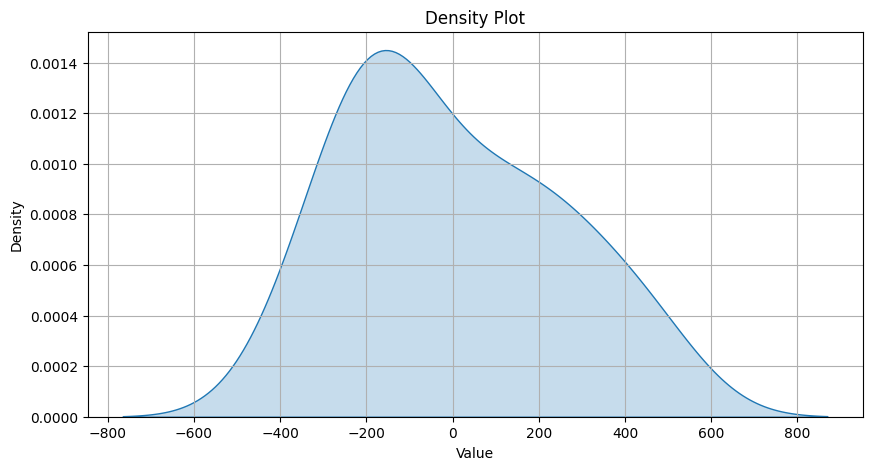

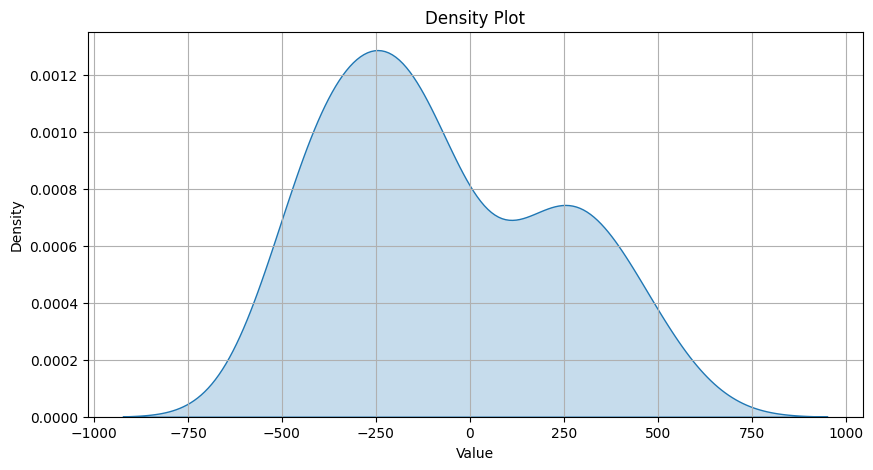

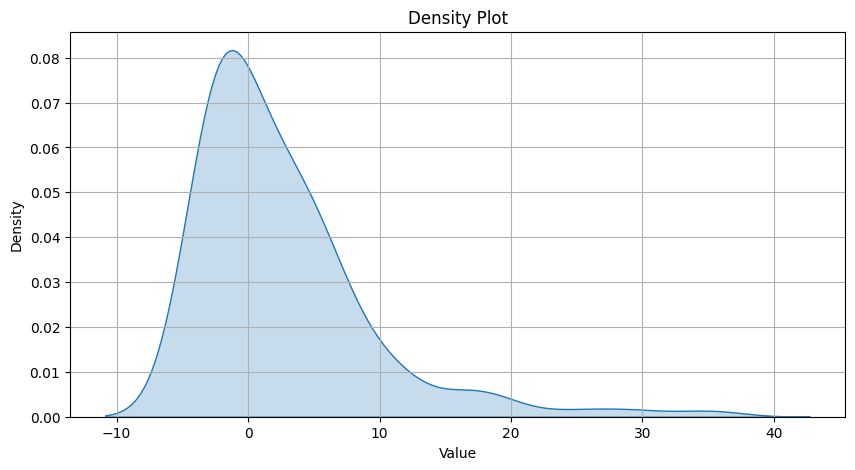

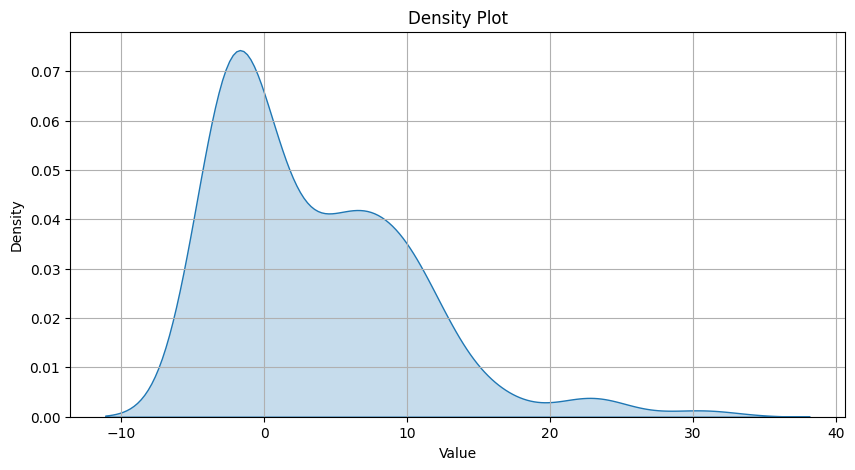

In [180]:
plot_density(np.sum(np.sum(distance_to_ref_patients, axis=1), axis=1))
plot_density(np.sum(np.sum(distance_to_ref_controls, axis=1), axis=1))
plot_density(np.sum(distance_to_ref_patients, axis=1)[0])
plot_density(np.sum(distance_to_ref_controls, axis=1)[0])

In [148]:
reference_matrix_2 = np.mean([
    np.where(patient_matrices['kl_divergence'] < 0.7, 0, 
                 patient_matrices['kl_divergence'])
    for patient_matrices in patients_connectomes.values()
])
distance_to_ref_patients_2 = [
    (reference_matrix_2 - np.where(patient_matrices['kl_divergence'] < 0.7, 0, 
                 patient_matrices['kl_divergence']))
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls_2 = [
    (reference_matrix_2 - np.where(patient_matrices['kl_divergence'] < 0.7, 0, 
                 patient_matrices['kl_divergence']))
    for patient_matrices in (controls_connectomes).values()]

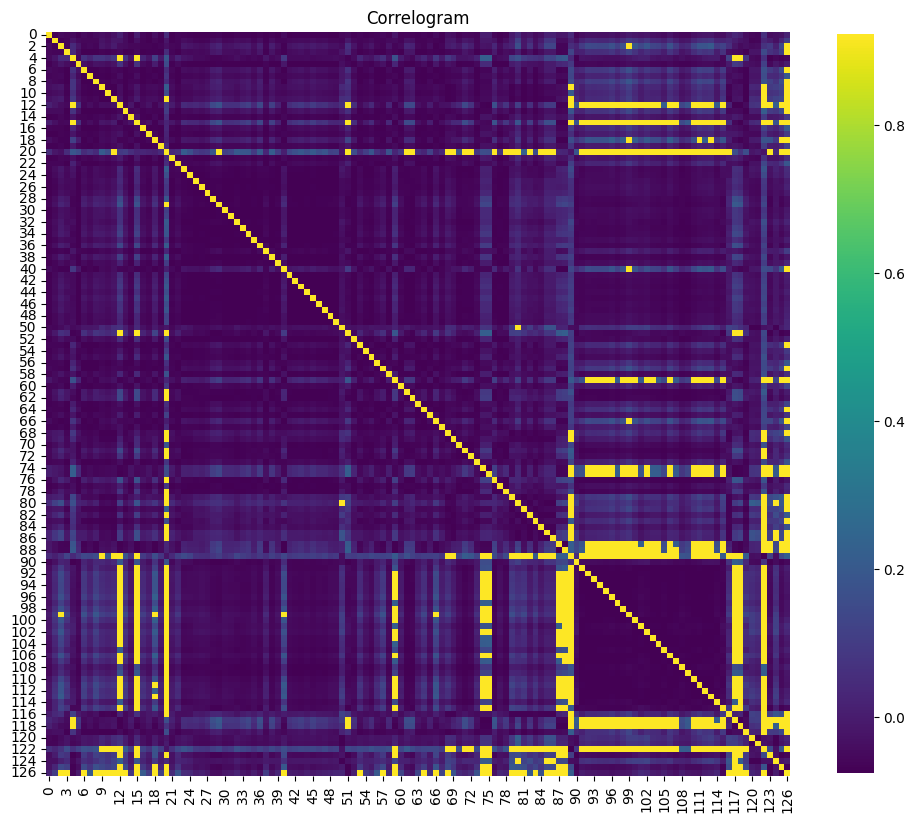

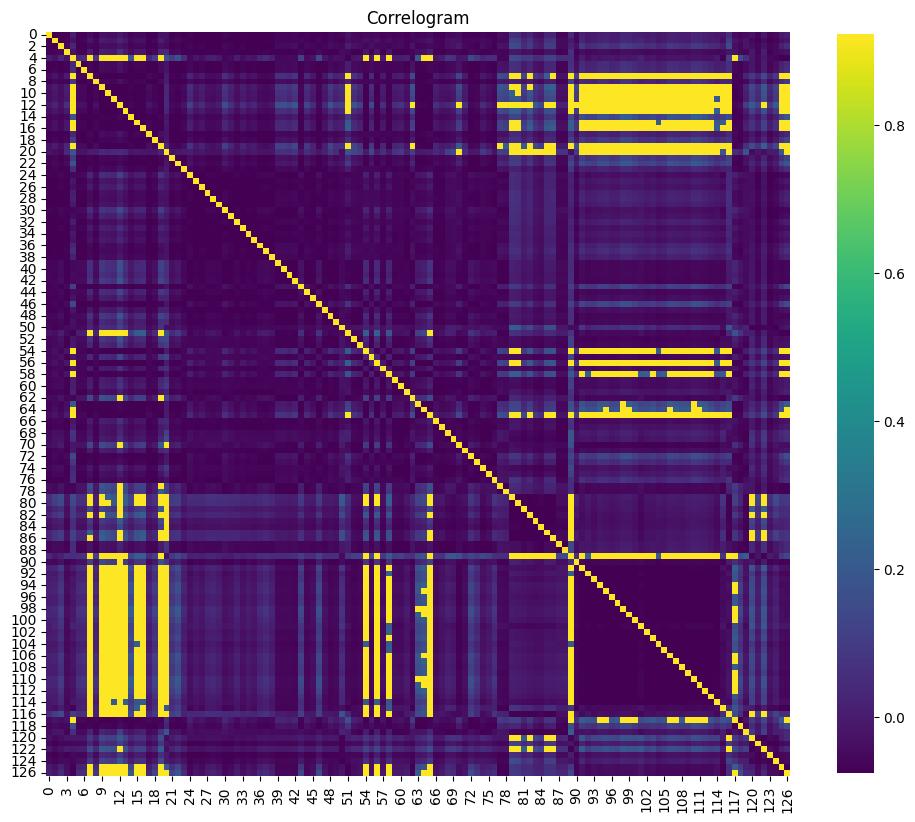

0.03390458066039478
5.912990574590979e-17
9.57916873395098e-13
0.031165612960360363
-0.006669742904416432
9.57916873395098e-13


In [176]:
plot_correlogram(distance_to_ref_patients_2[0])
plot_correlogram(distance_to_ref_controls_2[0])

print(np.var(distance_to_ref_patients_2))
print(np.mean(distance_to_ref_patients_2))
print(np.mean(np.sum(np.sum(distance_to_ref_patients_2, axis=1), axis=1)))
print(np.var(distance_to_ref_controls_2))
print(np.mean(distance_to_ref_controls_2))
print(np.mean(np.sum(np.sum(distance_to_ref_patients_2, axis=1), axis=1)))

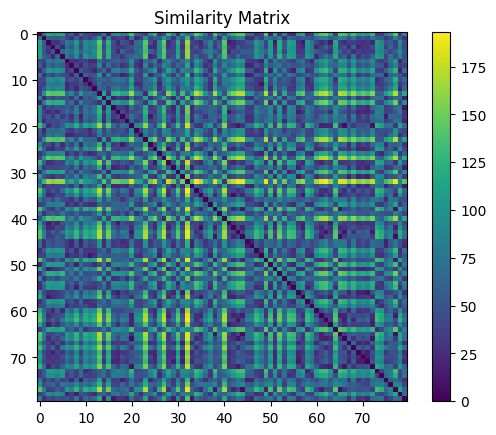

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [152]:
print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_spectral_distance(distance_to_ref_patients_2+distance_to_ref_controls_2)))


In [186]:
from scipy.stats import gaussian_kde

def compute_column_sum_probabilities(test_matrix, set_of_matrices, epsilon=0.01):
    """
    For each matrix in set_of_matrices (each n x n), compute the sum of each column.
    Learn the distribution of these sums using kernel density estimation.
    Then, for each column in the test_matrix, compute the sum and approximate the 
    probability that a sample from the learned distribution falls within [x-epsilon, x+epsilon].
    
    Parameters:
      test_matrix (np.ndarray): An n x n matrix.
      set_of_matrices (list of np.ndarray): A list of n x n matrices.
      epsilon (float): Half the width of the interval around the observed column sum.
    
    Returns:
      probabilities (np.ndarray): An array of probabilities (one per column of test_matrix).
    """
    # Gather all column sums from the dataset
    dataset_column_sums = []
    for mat in set_of_matrices:
        # Compute column sums for each matrix (resulting in an array of shape (n,))
        dataset_column_sums.extend(np.sum(mat, axis=0))
    dataset_column_sums = np.array(dataset_column_sums)
    
    # Learn the distribution using kernel density estimation (non-parametric)
    kde = gaussian_kde(dataset_column_sums)
    
    # Compute column sums for the test matrix
    test_column_sums = np.sum(test_matrix, axis=0)
    
    # For each test column sum, compute the probability mass in [x - epsilon, x + epsilon]
    probabilities = np.array([
        max(0, kde.integrate_box_1d(x - epsilon, x + epsilon))
        for x in test_column_sums
    ])
    
    return probabilities


In [191]:
controls_probs = []
patients_probs = []

for control in controls_list:
    col_sum_probs = compute_column_sum_probabilities(controls_connectomes[control]['kl_divergence'], [
        patient_matrices['kl_divergence']
        for patient_matrices in patients_connectomes.values()
    ], epsilon=0.001)
    controls_probs.append(np.sum(col_sum_probs))

#plot_density(col_sum_probs)
    
#print("Probability for each column sum:", np.sum(col_sum_probs))

for patient in patients_list:
    col_sum_probs = compute_column_sum_probabilities(patients_connectomes[patient]['kl_divergence'], [
        patient_matrices['kl_divergence']
        for patient_matrices in patients_connectomes.values()
    ], epsilon=0.001)
    patients_probs.append(np.sum(col_sum_probs))

#plot_density(col_sum_probs)
    
#print("Probability for each column sum:", np.sum(col_sum_probs))
print(patients_probs, "\n",np.mean(patients_probs), "\n", np.sum(patients_probs))
print(controls_probs, "\n", np.mean(controls_probs), "\n", np.sum(controls_probs))

[np.float64(0.017636101504213044), np.float64(0.026441860703869106), np.float64(0.02716951492470037), np.float64(0.024752488034452274), np.float64(0.026787367327996577), np.float64(0.025619111835283145), np.float64(0.02173354422313808), np.float64(0.02255280973790399), np.float64(0.018837086091819867), np.float64(0.0246320311190873), np.float64(0.023279189802335863), np.float64(0.022624767868185253), np.float64(0.01719619355130945), np.float64(0.015881778326509364), np.float64(0.025920345054101835), np.float64(0.01783847858164971), np.float64(0.02750774973815818), np.float64(0.02572766374134807), np.float64(0.024480893127385814), np.float64(0.026201512521887686), np.float64(0.02584522968063061), np.float64(0.022252841214884994), np.float64(0.023626085019054423), np.float64(0.015629138291924582), np.float64(0.02371084145497049), np.float64(0.025660278063833527), np.float64(0.02050551360756666)] 
 0.022964830190674083 
 0.6200504151482003
[np.float64(0.016287877946952006), np.float64(0.0

The columns of patients are not more likely than the columns of the control x(

### Experiment B: Let's go back to the standard approach and try to see what we can do